# Generate plots for figure 5

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import joblib
import pickle
from definitions import ROOT_DIR, TASK_TO_PRINT, NUM_MUSCLES, NUM_JOINTS
from helpers import get_pos_vel_act, plot_explained_variance_ratio, ev
from sklearn.decomposition import PCA

MyoSuite:> Registering Myo Envs


## Load the datasets for all tasks

In [4]:
task_df_dict = {
    "baoding": "baoding_sv_no_activity.h5",
    "early_baoding": "baoding_step_12_no_activity.h5",
    "hand_pose": "hand_pose.h5",
    "hand_reach": "hand_reach.h5",
    "reorient": "reorient.h5",
    "pen": "pen.h5"
}

data_dir = os.path.join(ROOT_DIR, "data")
df_dict = {
    key: pd.read_hdf(os.path.join(data_dir, "datasets", "rollouts", value))
    for key, value in task_df_dict.items()
}

In [5]:
task_pos_vel_act_dict = {}
for key, value in df_dict.items():
    pos, vel, muscle_act = get_pos_vel_act(value)
    task_pos_vel_act_dict[key] = {"pos": pos, "vel": vel, "muscle_act": muscle_act}

## Load the PCAs and project the poses and muscle activations onto them

In [6]:
task_list = ["baoding", "early_baoding"]
task_colors = {
    "baoding": "dodgerblue",
    "early_baoding": "blue",
    "pen": "blueviolet",
    "reorient": "violet",
    "hand_reach": "orange",
    "hand_pose": "red",
}

label_dict = {
    "best_to_worst": "High to low EV",
    "worst_to_best": "Low to high EV",
}
target_task_list = ["baoding", "early_baoding", "hand_pose", "hand_reach", "pen", "reorient"]

In [7]:
# create figure folder if it doesn't already exist
out_path = os.path.join(ROOT_DIR, "data", "figures", "fig_5")
os.makedirs(out_path, exist_ok=True)

Computing PCA for baoding
Computing PCA for early_baoding
Computing PCA for hand_pose
Computing PCA for hand_reach
Computing PCA for reorient
Computing PCA for pen


/tmp/ipykernel_57697/4138478284.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_57697/4138478284.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


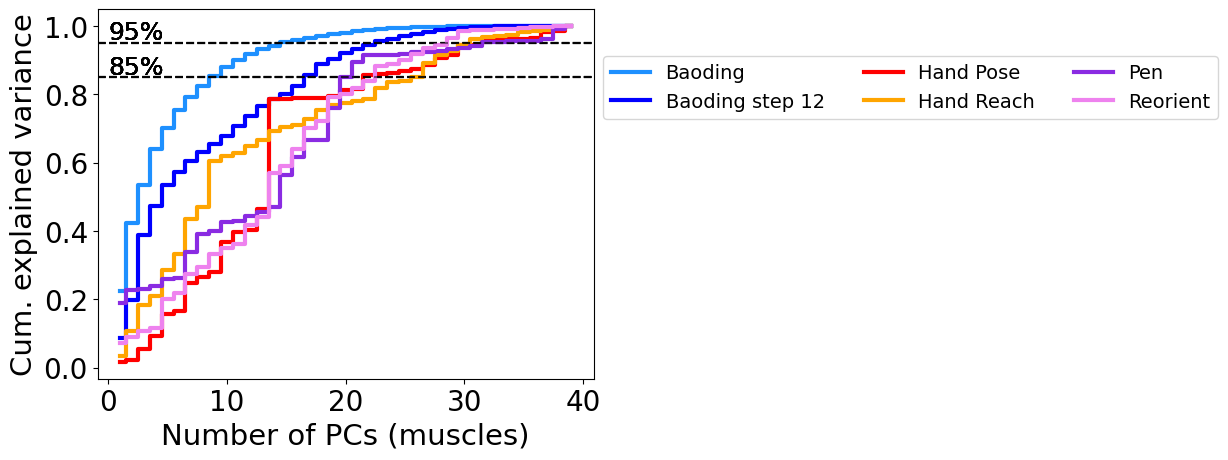

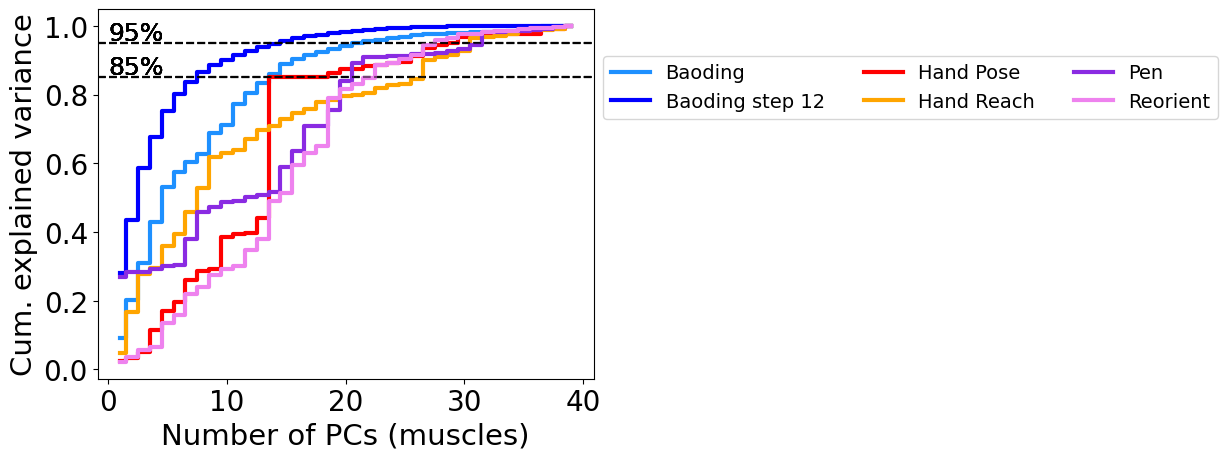

In [9]:
# Load the precomputed PCAs or compute them from scratch
load_pca = False
pca_dict = {}
for task in task_pos_vel_act_dict.keys():
    if load_pca:
        pca = joblib.load(os.path.join(ROOT_DIR, "data", "pca", f"pca_muscle_act_{task}.joblib"))
    else:
        pos_vel_act_dict = task_pos_vel_act_dict[task]
        muscle_act = pos_vel_act_dict["muscle_act"]
        print(f"Computing PCA for {task}")
        pca = PCA(n_components=NUM_MUSCLES).fit(muscle_act)
    pca_dict[task] = pca

# Plot the cumulative variance projected on the different PCA spaces
for base_task in task_list:
    fig, ax = plt.subplots()
    for target_task in TASK_TO_PRINT:
        pca = pca_dict[target_task]
        muscle_act = task_pos_vel_act_dict[base_task]["muscle_act"]
        muscle_act_projected = pca.transform(muscle_act)
        muscle_act_approx = pca.inverse_transform(muscle_act_projected)
        exp_var = ev(muscle_act, muscle_act_approx, pca.mean_)
        exp_var_ratio_list = [exp_var]
        for i in range(1, NUM_MUSCLES):
            muscle_act_projected[:, -i:] = 0
            muscle_act_approx = pca.inverse_transform(muscle_act_projected)
            exp_var = ev(muscle_act, muscle_act_approx, pca.mean_)
            exp_var_ratio_list.append(exp_var)
        exp_var_ratio_list.reverse()

        plot_explained_variance_ratio(exp_var_ratio_list, task_name=target_task, color=task_colors[target_task], ax=ax, fig=fig)
    ax.legend(bbox_to_anchor=(1, 0.9), fontsize=14, ncol=3)
    ax.set_xlabel('Number of PCs (muscles)', fontsize=21)
    fig.savefig(os.path.join(out_path, f"cum_var_muscle_act_{base_task}_onto_all.png"), format="png", dpi=600, bbox_inches="tight")
    fig.show()


Computing PCA for baoding
Computing PCA for early_baoding
Computing PCA for hand_pose
Computing PCA for hand_reach
Computing PCA for reorient
Computing PCA for pen


/tmp/ipykernel_57697/1439475144.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_57697/1439475144.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


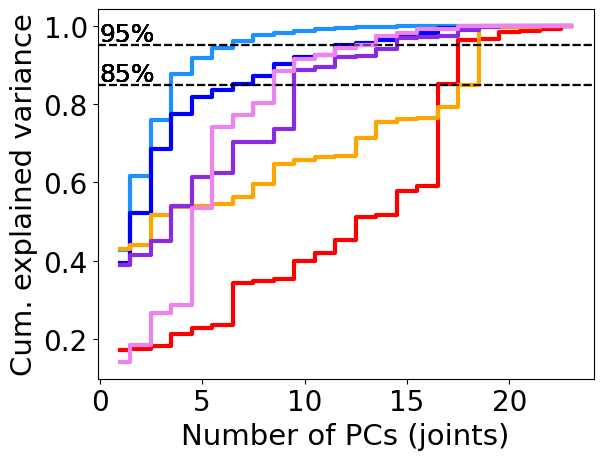

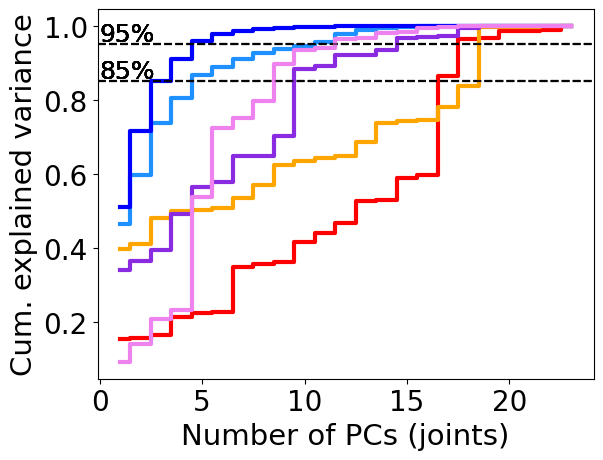

In [10]:
# Load the precomputed PCAs or compute them from scratch
load_pca = False
pca_dict = {}
for task in task_pos_vel_act_dict.keys():
    if load_pca:
        pca = joblib.load(os.path.join(ROOT_DIR, "data", "pca", f"pca_pos_{task}.joblib"))
    else:
        pos_vel_act_dict = task_pos_vel_act_dict[task]
        pos = pos_vel_act_dict["pos"]
        print(f"Computing PCA for {task}")
        pca = PCA(n_components=NUM_JOINTS).fit(pos)
    pca_dict[task] = pca
    
# Plot the cumulative variance projected on the different PCA spaces
for base_task in task_list:
    fig, ax = plt.subplots()
    # ax.set_title(f"Explained variance ratio for {task_to_print_dict[base_task]}", fontsize=21)
    for target_task in TASK_TO_PRINT:
        pca = pca_dict[target_task]
        pos = task_pos_vel_act_dict[base_task]["pos"]
        pos_projected = pca.transform(pos)
        pos_approx = pca.inverse_transform(pos_projected)
        exp_var = ev(pos, pos_approx, pca.mean_)
        exp_var_ratio_list = [exp_var]
        for i in range(1, NUM_JOINTS):
            pos_projected[:, -i:] = 0
            pos_approx = pca.inverse_transform(pos_projected)
            exp_var = ev(pos, pos_approx, pca.mean_)
            exp_var_ratio_list.append(exp_var)
        exp_var_ratio_list.reverse()

        plot_explained_variance_ratio(exp_var_ratio_list, task_name=target_task, color=task_colors[target_task], ax=ax, fig=fig)
    plt.xlabel('Number of PCs (joints)', fontsize=21)
    fig.savefig(os.path.join(out_path, f"cum_var_pos_{base_task}_onto_all.png"), format="png", dpi=600, bbox_inches="tight")
    fig.show()

## Load the performance decay data (without recomputing them) and make the plots

/tmp/ipykernel_57697/2329546396.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


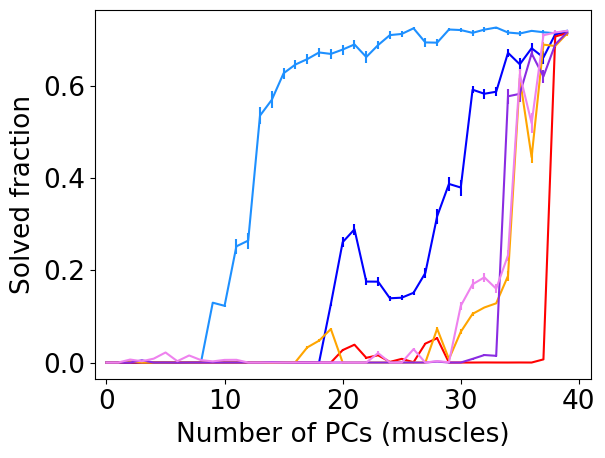

In [11]:
# Load the precomputed performance datasets
task_perf_dict = {}
for target_task in target_task_list:
    perf_path = os.path.join(ROOT_DIR, "data", "datasets", "csi", f"performance_action_components_{target_task}_best_to_worst.pkl")
    perf = pickle.load(open(perf_path,'rb'))
    task_perf_dict[target_task] = perf
    
fig, ax = plt.subplots()
for task, performance_components in task_perf_dict.items():
    color = task_colors[task]
    # We insert a 0 because the performance with 0 PCs is 0
    perfs_mean = np.array([0] + [d['solved_frac_mean'] for d in performance_components[::-1]])
    perfs_sem = np.array([0] + [d['solved_frac_sem'] for d in performance_components[::-1]])
    ax.errorbar(np.arange(NUM_MUSCLES + 1), perfs_mean, yerr=perfs_sem, fmt='-', label=TASK_TO_PRINT[task], color=color)
    
ax.set_xlabel('Number of PCs (muscles)',fontsize=19,labelpad=5)
ax.set_ylabel('Solved fraction',fontsize=19,labelpad=5)
ax.tick_params(axis="both", labelsize=19)
ax.set_xticks(np.arange(0, 41, 10))
ax.set_xlim((-1, 41))
fig.savefig(os.path.join(out_path, "pca_performance_contrib.png"), format="png", dpi=600, bbox_inches="tight")
fig.show()

/tmp/ipykernel_57697/206659169.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


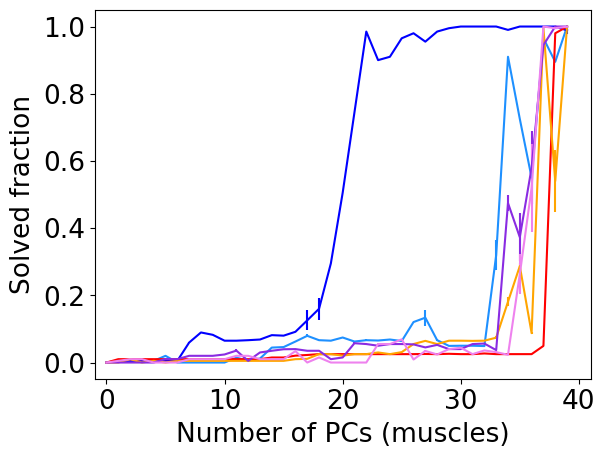

In [12]:
# Load the precomputed performance datasets
task_perf_dict = {}
for target_task in target_task_list:
    perf_path = os.path.join(ROOT_DIR, "data", "datasets", "csi", f"performance_step_12_{target_task}_best_to_worst.pkl")
    perf = pickle.load(open(perf_path,'rb'))
    task_perf_dict[target_task] = perf
    
fig, ax = plt.subplots()
for task, performance_components in task_perf_dict.items():
    color = task_colors[task]
    # We insert a 0 because the performance with 0 PCs is 0
    perfs_mean = np.array([0] + [d['solved_frac_mean'] for d in performance_components[::-1]])
    perfs_sem = np.array([0] + [d['solved_frac_sem'] for d in performance_components[::-1]])
    ax.errorbar(np.arange(NUM_MUSCLES + 1), perfs_mean, yerr=perfs_sem, fmt='-', label=TASK_TO_PRINT[task], color=color)
    
ax.set_xlabel('Number of PCs (muscles)',fontsize=19,labelpad=5)
ax.set_ylabel('Solved fraction',fontsize=19,labelpad=5)
ax.tick_params(axis="both", labelsize=19)
ax.set_xticks(np.arange(0, 41, 10))
ax.set_xlim((-1, 41))
fig.savefig(os.path.join(out_path, "pca_performance_contrib_step_12.png"), format="png", dpi=600, bbox_inches="tight")
fig.show()